## Group Finder central/satellite classification
We determine whether or not changing the central/satellite classification to the groupfinder output impacts the SFMS fits.

In [1]:
import numpy as np 
import corner as DFM
# -- local -- 
import env
import util as UT
import catalogs as Cats
from fstarforms import fstarforms
from scipy.stats import multivariate_normal as MNorm

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
def Catalog_SimCentrals(cat_name): 
    ''' Return logM and logSFR of central galaxies as defined by the 
    simulation
    '''
    Cat = Cats.Catalog()
    _logM, _logSFR, w, censat = Cat.Read(cat_name, keepzeros=True, silent=True)
    iscen = ((censat == 1) & np.invert(Cat.zero_sfr))
    return _logM[iscen], _logSFR[iscen]

def Catalog_GFCentrals(cat_name, cen='pure'): 
    ''' Return logM and logSFR of central galaxies as defined by Jeremy's
    group catalog. 
    '''
    Cat = Cats.Catalog()
    _logM, _logSFR, w, censat = Cat.Read(cat_name, keepzeros=True, silent=True)
    
    psat = Cat.GroupFinder(cat_name)
    if cen == 'pure': cut = 0.01
    elif cen == 'all': cut = 0.5
    iscen = ((psat < cut) & np.invert(Cat.zero_sfr))
    return _logM[iscen], _logSFR[iscen]

In [4]:
for i_c, cat in enumerate(['illustris', 'eagle', 'mufasa']): 
    for i_t, tscale in enumerate(['inst', '100myr']):     
        logM_scen, logSFR_scen = Catalog_SimCentrals(cat+'_'+tscale)
        logM_gcen_pure, _ = Catalog_GFCentrals(cat+'_'+tscale)
        logM_gcen_all, _ = Catalog_GFCentrals(cat+'_'+tscale, cen='all')
        print('========%s=========' % cat)
        print('%i central galaxies in simulation' % len(logM_scen))
        print('%i pure central galaxies in group finder' % len(logM_gcen_pure))
        print('%i all central galaxies in group finder' % len(logM_gcen_all))

/Users/chang/projects/LetsTalkAboutQuench/letstalkaboutquench/catalogs.py:75: RuntimeWarning: divide by zero encountered in log10
  logSFR = np.log10(_ssfr) + logM # calculate log SFR from sSFR


========illustris=========
46813 central galaxies in simulation
39310 pure central galaxies in group finder
45480 all central galaxies in group finder
========illustris=========
40237 central galaxies in simulation
34332 pure central galaxies in group finder
39171 all central galaxies in group finder


/Users/chang/projects/LetsTalkAboutQuench/letstalkaboutquench/catalogs.py:94: RuntimeWarning: divide by zero encountered in log10
  logSFR = np.log10(_SFR) # log SFRs


========eagle=========
14047 central galaxies in simulation
13030 pure central galaxies in group finder
14913 all central galaxies in group finder
========eagle=========
10768 central galaxies in simulation
10043 pure central galaxies in group finder
11489 all central galaxies in group finder
========mufasa=========
4281 central galaxies in simulation
4709 pure central galaxies in group finder
5584 all central galaxies in group finder
========mufasa=========
2498 central galaxies in simulation
2620 pure central galaxies in group finder
2843 all central galaxies in group finder


See if the group finder central/satellite classification impacts the $SFR$-$M_*$ relation.

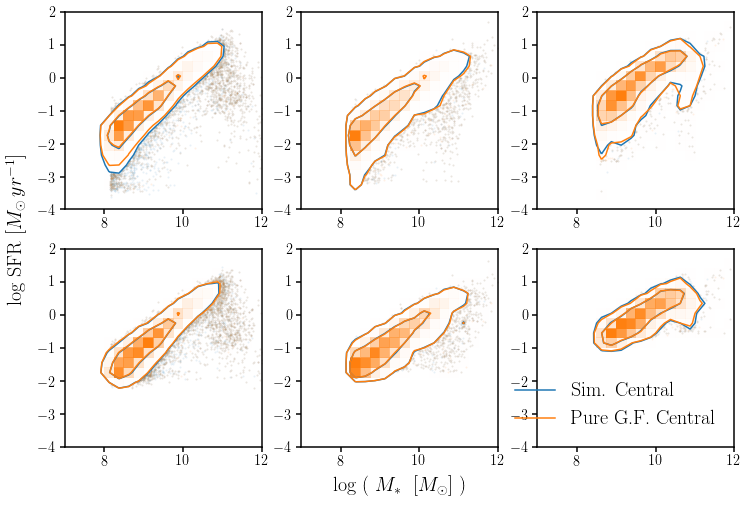

In [5]:
fig = plt.figure(figsize=(12, 8))
bkgd = fig.add_subplot(111, frameon=False)
for i_c, cat in enumerate(['illustris', 'eagle', 'mufasa']): 
    for i_t, tscale in enumerate(['inst', '100myr']): 
        # simulation centrals
        logM_scen, logSFR_scen = Catalog_SimCentrals(cat+'_'+tscale)
        logM_gcen, logSFR_gcen = Catalog_GFCentrals(cat+'_'+tscale, cen='pure')

        sub = fig.add_subplot(2,3,1+i_c+3*i_t)
        DFM.hist2d(logM_scen, logSFR_scen, color='C0', levels=[0.68, 0.95], range=[[7.,12.],[-4.,2.]], 
                   plot_datapoints=True, fill_contours=False, plot_density=False, ax=sub)
        sub.plot(np.zeros(2), np.zeros(2), c='C0', label='Sim. Central')
        DFM.hist2d(logM_gcen, logSFR_gcen, color='C1', levels=[0.68, 0.95], range=[[7.,12.],[-4.,2.]], 
                   plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
        sub.plot(np.zeros(2), np.zeros(2), c='C1', label='Pure G.F. Central')
        sub.set_xlim([7., 12.])
        sub.set_ylim([-4., 2.])
sub.legend(loc='lower right', prop={'size':20})
bkgd.set_xlabel(r'log ( $M_* \;\;[M_\odot]$ )', labelpad=10, fontsize=20)
bkgd.set_ylabel(r'log SFR $[M_\odot \, yr^{-1}]$', labelpad=10, fontsize=20)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

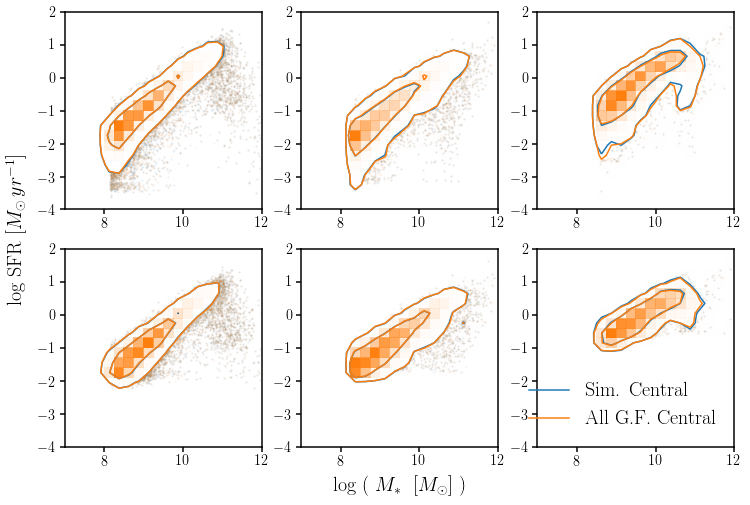

In [6]:
fig = plt.figure(figsize=(12, 8))
bkgd = fig.add_subplot(111, frameon=False)
for i_c, cat in enumerate(['illustris', 'eagle', 'mufasa']): 
    for i_t, tscale in enumerate(['inst', '100myr']): 
        # simulation centrals
        logM_scen, logSFR_scen = Catalog_SimCentrals(cat+'_'+tscale)
        logM_gcen, logSFR_gcen = Catalog_GFCentrals(cat+'_'+tscale, cen='all')

        sub = fig.add_subplot(2,3,1+i_c+3*i_t)
        DFM.hist2d(logM_scen, logSFR_scen, color='C0', levels=[0.68, 0.95], range=[[7.,12.],[-4.,2.]], 
                   plot_datapoints=True, fill_contours=False, plot_density=False, ax=sub)
        sub.plot(np.zeros(2), np.zeros(2), c='C0', label='Sim. Central')
        DFM.hist2d(logM_gcen, logSFR_gcen, color='C1', levels=[0.68, 0.95], range=[[7.,12.],[-4.,2.]], 
                   plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
        sub.plot(np.zeros(2), np.zeros(2), c='C1', label='All G.F. Central')
        sub.set_xlim([7., 12.])
        sub.set_ylim([-4., 2.])
sub.legend(loc='lower right', prop={'size':20})
bkgd.set_xlabel(r'log ( $M_* \;\;[M_\odot]$ )', labelpad=10, fontsize=20)
bkgd.set_ylabel(r'log SFR $[M_\odot \, yr^{-1}]$', labelpad=10, fontsize=20)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

There's little difference in the $SFR-M_*$ relation. More quantitatively, lets see if there's a significant difference in the SFMS fits

In [7]:
def fSFMS_central(cen, n_mc=20): 
    fig = plt.figure(figsize=(12, 8))
    bkgd = fig.add_subplot(111, frameon=False)
    for i_c, cat in enumerate(['illustris', 'eagle', 'mufasa']): 
        for i_t, tscale in enumerate(['inst', '100myr']): 
            # simulation centrals
            logM_scen, logSFR_scen = Catalog_SimCentrals(cat+'_'+tscale)
            logM_gcen, logSFR_gcen = Catalog_GFCentrals(cat+'_'+tscale, cen=cen)

            fSFMS = fstarforms()
            fsfms_sfr_scen, fsfms_sfr_gcen = [], [] 
            for i in range(n_mc): 
                fsfms_scen_i = fSFMS.fit(logM_scen, logSFR_scen, method='gaussmix', 
                                         dlogm=0.2, fit_range=[8.,11.4], maxcomp=3, silent=True) 

                fsfms_gcen_i = fSFMS.fit(logM_gcen, logSFR_gcen, method='gaussmix', 
                                       dlogm=0.2, fit_range=[8.,11.4], maxcomp=3, silent=True) 
                fsfms_sfr_scen.append(fsfms_scen_i[1])
                fsfms_sfr_gcen.append(fsfms_gcen_i[1])
                
            fsfms_scen = [fsfms_scen_i[0], np.mean(fsfms_sfr_scen, axis=0)]
            fsfms_gcen = [fsfms_gcen_i[0], np.mean(fsfms_sfr_gcen, axis=0)]
            sub = fig.add_subplot(2,3,1+i_c+3*i_t)
            DFM.hist2d(logM_scen, logSFR_scen, color='k', levels=[0.68, 0.95], range=[[7.,12.],[-4.,2.]], 
                       contour_kwargs={'linewidths':1, 'linestyles':'dotted'},
                       plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
            DFM.hist2d(logM_gcen, logSFR_gcen, color='C1', levels=[0.68, 0.95], range=[[7.,12.],[-4.,2.]], 
                       contour_kwargs={'linewidths':1, 'linestyles':'dotted'},
                       plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)

            sub.scatter(fsfms_scen[0], fsfms_scen[1], marker='x', color='k', lw=1, s=40, label='Sim. Central')
            sub.scatter(fsfms_gcen[0], fsfms_gcen[1], marker='x', color='C1', lw=1, s=40, label=cen+' G.F. Central')

            sub.set_xlim([7., 12.])
            sub.set_ylim([-4., 2.])
    sub.legend(loc='lower right', handletextpad=0., prop={'size':20})
    bkgd.set_xlabel(r'log ( $M_* \;\;[M_\odot]$ )', labelpad=10, fontsize=20)
    bkgd.set_ylabel(r'log SFR $[M_\odot \, yr^{-1}]$', labelpad=10, fontsize=20)
    bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

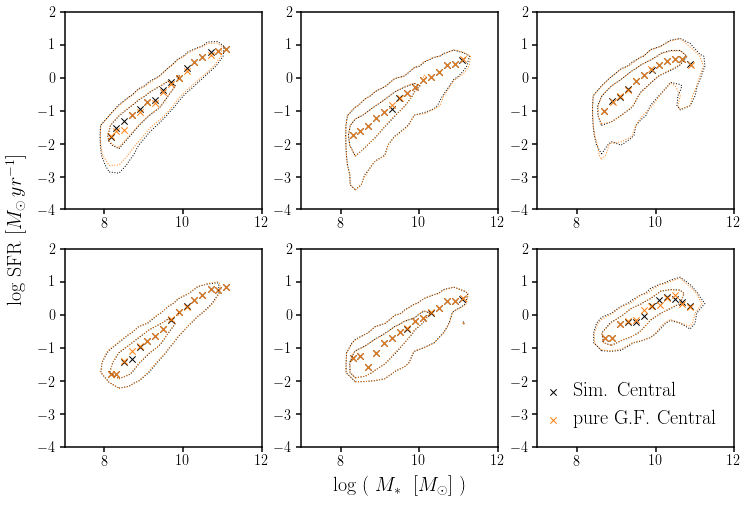

In [8]:
fSFMS_central('pure')

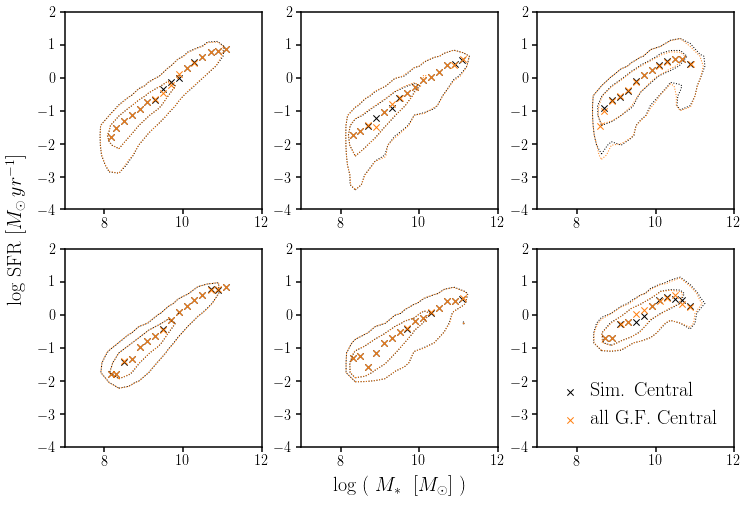

In [9]:
fSFMS_central('all')

What about the power-law fits to the SFMS derived from the SFMS fit

In [10]:
def powerlaw_SFMS_central(cen, n_mc=20): 
    m_arr = np.linspace(7., 12., 100)
    fig = plt.figure(figsize=(12, 8))
    bkgd = fig.add_subplot(111, frameon=False)
    for i_c, cat in enumerate(['illustris', 'eagle', 'mufasa']): 
        for i_t, tscale in enumerate(['inst', '100myr']): 
            # simulation centrals
            logM_scen, logSFR_scen = Catalog_SimCentrals(cat+'_'+tscale)
            logM_gcen, logSFR_gcen = Catalog_GFCentrals(cat+'_'+tscale, cen=cen)

            f_sfms_scen, f_sfms_gcen = [], [] 
            for i in range(n_mc): 
                fSFMS = fstarforms()
                _ = fSFMS.fit(logM_scen, logSFR_scen, method='gaussmix', 
                                         dlogm=0.2, fit_range=[8.,11.4], maxcomp=3, silent=True) 
                f_sfms_scen_i = fSFMS.powerlaw(logMfid=10.5)
                f_sfms_scen.append(f_sfms_scen_i(m_arr))

                fSFMS_gf = fstarforms()
                _ = fSFMS_gf.fit(logM_gcen, logSFR_gcen, method='gaussmix', 
                                       dlogm=0.2, fit_range=[8.,11.4], maxcomp=3, silent=True) 
                f_sfms_gcen_i = fSFMS_gf.powerlaw(logMfid=10.5)
                f_sfms_gcen.append(f_sfms_gcen_i(m_arr))
                
            sub = fig.add_subplot(2,3,1+i_c+3*i_t)
            sub.plot(m_arr, np.mean(np.array(f_sfms_scen), axis=0), c='k', label='Sim. Central')
            sub.plot(m_arr, np.mean(np.array(f_sfms_gcen), axis=0), c='C1', label=cen+' G.F. Central')
            
            sub.set_xlim([8., 12.])
            sub.set_ylim([-2., 2.])
    sub.legend(loc='upper left', handletextpad=0., prop={'size':15})
    bkgd.set_xlabel(r'log ( $M_* \;\;[M_\odot]$ )', labelpad=10, fontsize=20)
    bkgd.set_ylabel(r'log SFR $[M_\odot \, yr^{-1}]$', labelpad=10, fontsize=20)
    bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

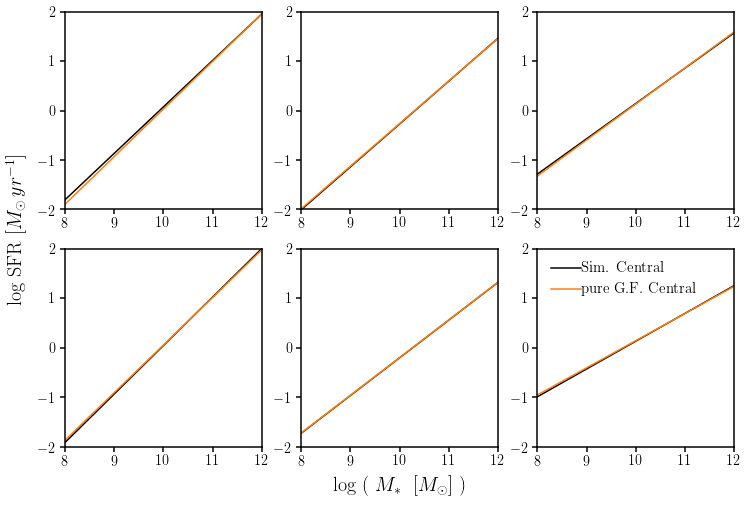

In [11]:
powerlaw_SFMS_central('pure')

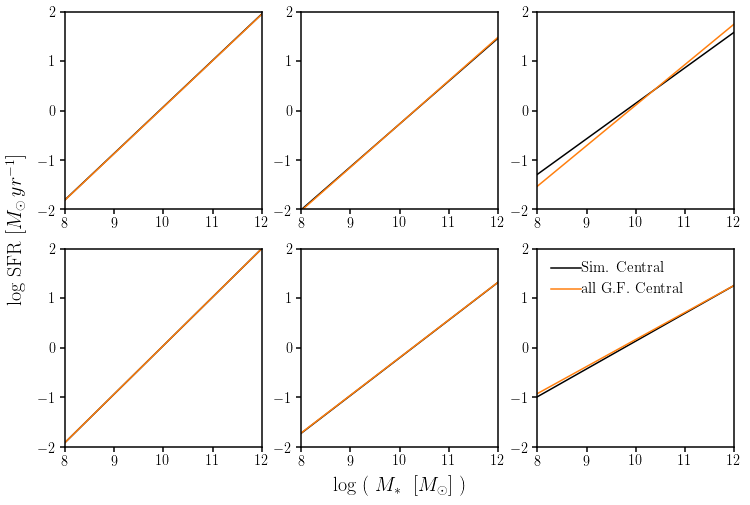

In [12]:
powerlaw_SFMS_central('all')